# Unsupervised learning of Maxwell's equations

In [1]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from pdb import set_trace as breakpoint
# from tensorboardX import SummaryWriter

import numpy as np
import matplotlib.pyplot as plt
import h5py

# from datasets.generators import *
from datasets.generators1d import * 
from models.utils import pbar

## Unsupervised 1D convolutional model

In [2]:
# make_batch(perm_alternating_layers, "datasets/test_1d_unsupervised.hdf5", "alternating_layers_no_npml", N=10**4, npml=0)

In [3]:
data_batch = load_batch("datasets/test_1d_unsupervised.hdf5", "alternating_layers")

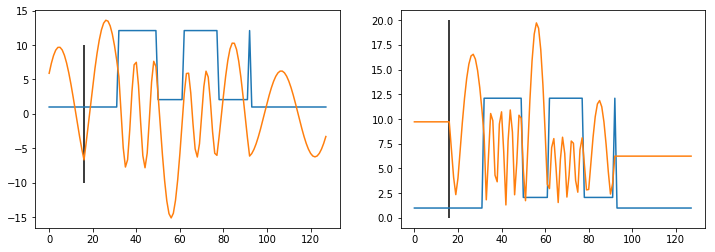

In [4]:
n = np.random.randint(0,500)
f, axarr = plt.subplots(1, 2, figsize=(12,4))

epsilons = data_batch["epsilons"][n]
src_x = data_batch["src"][n]
Hx = data_batch["Hx"][n]
Hy = data_batch["Hy"][n]
Ez = data_batch["Ez"][n]
        
axarr[0].plot(epsilons)
axarr[0].plot(np.imag(Ez))
axarr[0].vlines(src_x, -10, 10)

axarr[1].plot(epsilons)
axarr[1].plot(np.abs(Ez))
axarr[1].vlines(src_x, 0, 20)

plt.show()

In [5]:
diffs = np.diff(np.imag(Ez), n=2)
ez = np.imag(Ez)[1:-1]
# ez = np.real(Ez)[0:-2]
eps = epsilons[1:-1]
# eps = epsilons[2:]

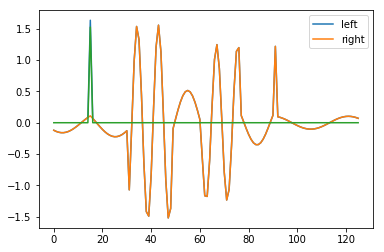

1.526814027803995


In [6]:
OMEGA = 1.215e15
MU0 = 4 * np.pi * 10**-7
EPSILON0 =  8.854187817620e-12 
SCALE = 1e-15
C = 299792458.0
L0 = 1e-6
PIXEL_SIZE = 0.05 * L0
wavelength = 2 * np.pi * C / OMEGA

x = PIXEL_SIZE * (np.arange(eps.shape[0]) - src_x)
# Check wave equation terms match
left = SCALE * diffs / PIXEL_SIZE**2
right = SCALE * -OMEGA**2 * MU0 * EPSILON0 * eps * ez
plt.plot(left, label="left")
plt.plot(right, label="right")
# Cosine fit
# plt.plot(2 * np.cos(np.sqrt(eps) * OMEGA/C * x))
# Residual
plt.plot((left - right))
plt.legend()
plt.show()

print((left - right)[15])

### 1D convolutional model definitions

In [16]:
class Perm1dDataset_test(Dataset):
    
    def __init__(self, hdf5_file, batch_name, kernel_sizes = []):
        
        data = load_batch(hdf5_file, batch_name)
        
        self.epsilons = data["epsilons"] 
        self.src = data["src"]
        self.Ez = data["Ez"]
                
        self.input_size = self.Ez[0].shape[0]
        output_size = self.input_size
        for kernel_size in kernel_sizes:
            stride = 1
            output_size = (output_size - kernel_size) / stride + 1
        self.output_size = int(output_size)
        
    def __len__(self):
        return len(self.epsilons)

    def __getitem__(self, i):
        epsilons = torch.tensor(self.epsilons[i])
        src_x = self.src[i]
        fields = torch.tensor(np.imag(self.Ez[i])) # TODO: change to real
        return epsilons.float(), src_x, fields.float()

class Perm1dDataset(Dataset):
    
    def __init__(self, epsilon_generator, kernel_sizes = [], N=1000, input_size=128, infinite_mode=False):
        self.input_size = input_size
        output_size = self.input_size
        for kernel_size in kernel_sizes:
            stride = 1
            output_size = (output_size - kernel_size) / stride + 1
        self.output_size = int(output_size)
        
        self.epsilon_generator = epsilon_generator
        self.epsilon_samples = []
        self.src_samples = []
        self.N = N
        self.infinite_mode = infinite_mode
        
    def __len__(self):
        if self.infinite_mode:
            return int(1e100)
        else:
            return int(self.N)

    def __getitem__(self, i):
        if i >= len(self.epsilon_samples) and not self.infinite_mode:
#             src = torch.zeros(self.input_size)
#             src_x = np.random.randint(1,32)
#             src[src_x] = 1.0
            epsilons = np.ones(self.input_size)
            epsilons[32:96] = self.epsilon_generator()
            epsilons = torch.tensor(epsilons).float()
            src_x = np.random.randint(1,127-1) # 16 # TODO
            self.epsilon_samples.append(epsilons)
            self.src_samples.append(src_x)
            return epsilons, src_x, torch.zeros(epsilons.shape).float()
        else:
            epsilons = self.epsilon_samples[i]
            src_x = self.src_samples[i]
            return epsilons.float(), src_x, torch.zeros(epsilons.shape).float()

In [17]:
def tensor_diff(a, n=1, axis=-1):
    '''PyTorch equivalent of numpy.diff()'''
    if n == 0:
        return a
    if n < 0:
        raise ValueError("order must be non-negative but got " + repr(n))
    length = a.shape[axis] - 1
    a0 = a.narrow(axis, 0, length)
    a1 = a.narrow(axis, 1, length)
    return tensor_diff(a1 - a0, n=n-1, axis=axis)

In [18]:
# class MaxwellConv(nn.Module):
#     def __init__(self, input_size=128):
#         super().__init__()
        
#         self.input_size = input_size
#         self.input_channels = 1
#         self.output_channels = 2
        
#         k0 = np.ceil(1.5 * wavelength / dl)
#         self.kernel_sizes = [5, 11, 7, 5, 3]
#         self.conv_channels = [16, 16, 24, 32, 24]

#         output_size = self.input_size
#         for kernel_size in self.kernel_sizes:
#             stride = 1
#             output_size = (output_size - kernel_size) / stride + 1
#         self.output_size = int(output_size)

#         layers = []
        
#         in_channels = self.input_channels # number of input channels
#         for out_channels, kernel_size in zip(self.conv_channels, self.kernel_sizes):
#             layers.append(nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=0))
#             in_channels = out_channels
        
#         self.convolutions = nn.ModuleList(layers)
#         self.conv_output_size = self.output_size * self.conv_channels[-1]
    
#         self.hidden_size = 256
#         self.dense1 = nn.Linear(self.conv_output_size, self.hidden_size)
#         self.dense2 = nn.Linear(self.hidden_size, 1)
        
#     def forward(self, x):
#         out = x
#         for i, layer in enumerate(self.convolutions):
#             out = layer(out)
#             out = nn.ReLU()(out)
            
#         # Flatten
#         out = torch.reshape(out, (-1, self.conv_output_size))
        
#         # Dense layer
#         out = self.dense1(out)
#         out = nn.ReLU()(out)
#         out = self.dense2(out)
#         return out
    
class MaxwellDense(nn.Module):
    def __init__(self, size=128):
        super().__init__()
        
        self.size = size

#         self.layer_dims = [self.size, 256, 512, 512, 256, self.size]
        self.layer_dims = [2 * self.size, 256, 256, self.size]

        layers_amp = []
        layers_phi = []
        for i in range(len(self.layer_dims) - 1):
            layers_amp.append(nn.Linear(self.layer_dims[i], self.layer_dims[i+1]))
            layers_phi.append(nn.Linear(self.layer_dims[i], self.layer_dims[i+1]))
            
        self.layers_amp = nn.ModuleList(layers_amp)
        self.layers_phi = nn.ModuleList(layers_phi)
        
    def forward_amplitude_phase(self, x):
        A = x
        for i, layer in enumerate(self.layers_amp):
            A = layer(A)
            if i < len(self.layers_amp) - 1:
                A = nn.ReLU()(A)
                
        phi = x
        for i, layer in enumerate(self.layers_phi):
            phi = layer(phi)
            if i < len(self.layers_amp) - 1:
                phi = nn.ReLU()(phi)
        
        return A, phi
    
    def get_fields(self, epsilons, src):
        # Get amplitude and phase vectors
        data = torch.cat((epsilons, src), dim=-1)
        A, phi = self.forward_amplitude_phase(data)#epsilons)
            
        # Combine to form waveform
        x = (PIXEL_SIZE * (torch.arange(self.size) # - src_x
                          )).float()
        fields = A * torch.cos(OMEGA / C * torch.sqrt(epsilons) * x + phi)
        return fields
        
    def forward(self, epsilons, src):
        
        
        
        fields = self.get_fields(epsilons, src)

        eps = epsilons[:,1:-1]
        E = fields[:,1:-1]
        
        # Compute Maxwell operator on fields
        curl_curl_E = tensor_diff(fields, n=2)
        left_factor =  SCALE / PIXEL_SIZE**2
        right_factor = SCALE * -OMEGA**2 * MU0 * EPSILON0
        
        out = (left_factor * curl_curl_E) - (right_factor * eps * E) - src[:,1:-1]
        
        return out

In [19]:
def perm_generator_vacuum():
    return np.ones(64)

In [20]:
# Device configuration
device = torch.device('cpu')

# Create a model   
model = MaxwellDense().to(device)
# writer = SummaryWriter()

# Create data loaders
batch_size = 1

# permittivity_data = Perm1dDataset("datasets/test_1d.hdf5", "alternating_layers", model.kernel_sizes)
# train_size = int(0.9 * len(permittivity_data))
# test_size = len(permittivity_data) - train_size
# train_data, test_data = random_split(permittivity_data, [train_size, test_size])
train_data = Perm1dDataset(perm_alternating_layers)
test_data = Perm1dDataset_test("datasets/test_1d_unsupervised.hdf5", "alternating_layers")
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

In [21]:
# Hyperparameters
num_epochs = 10
learning_rate = 0.01

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, weight_decay=0.1)
# losses = []

# Train the model
model.train()
total_step = len(train_loader)
epoch_iterator = pbar(range(num_epochs))
params = []

for epoch in epoch_iterator:
    
    iterator = pbar(train_loader)
    for epsilons, src_x, _ in iterator:
        
        src = torch.zeros(*epsilons.shape)
        src[:,src_x] = 1.526814027933079
        
        epsilons = epsilons.to(device)
        src = src.to(device)
        
        # Forward pass
        outputs = model(epsilons, src)
        loss = criterion(outputs, torch.zeros(outputs.shape))
#         losses.append(loss.item())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        
#         breakpoint() 
        
        optimizer.step()
        
        iterator.set_description("ℒ = {:.4f}".format(loss.item()), refresh=False)
    params.append([tensor.clone() for tensor in model.parameters()])

# Save the model checkpoint
torch.save(model.state_dict(), 'model1d.ckpt')

NameError: name 'losses' is not defined

In [25]:
torch.equal(params[0][0], params[9][0])

True

In [46]:
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
data_list = []
src_x_list = []
labels_list = []
outputs_list = []

with torch.no_grad():
    for data, src_x, labels in pbar(test_loader):
        data = data.to(device)
        labels = labels.to(device)
        outputs = model(data, src_x)
        data_list.append(data)
        src_x_list.append(src_x)
        labels_list.append(labels)
        outputs_list.append(outputs)
        
t_true = [tensor.item() for tensor in labels_list]
t_pred = [tensor.item() for tensor in outputs_list]

RuntimeError: Expected object of type torch.LongTensor but found type torch.ShortTensor for argument #3 'other'

In [85]:
model.eval()
data_test = torch.tensor([np.ones(128)]).float()
src_x_test = np.random.randint(1,126)
outputs = model.get_fields(data_test, src_x_test)

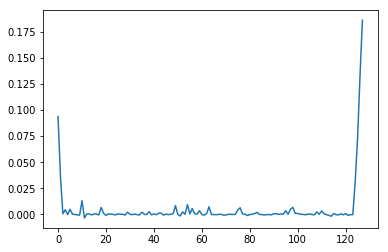

In [86]:
plt.plot(outputs.detach().numpy()[0])
plt.show()